In [1]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm_notebook
import pandas as pd
from keras.utils import np_utils
%matplotlib inline

/Users/TenzinNorden/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/TenzinNorden/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Logic Based FizzBuzz Function [Software 1.0]

In [2]:
def fizzbuzz(n):
    
    # Logic-based # will give 100% accurate output
    #if remainder is 0, return fizzbuzz
    if n % 3 == 0 and n % 5 == 0:
        return 'FizzBuzz'
    elif n % 3 == 0:
        return 'Fizz'
    elif n % 5 == 0:
        return 'Buzz'
    else:
        return 'Other'

## Create Training and Testing Datasets in CSV Format

In [3]:
def createInputCSV(start,end,filename):
    
    # Why list in Python?
    # create a list  in which the input and output can be appended. list in python is easy to handle
    inputData   = []
    outputData  = []
    
    # Why do we need training Data?
    # For a supervised machine learning, we know the correct answer. 
    #So, training Data is needed to train the machine learning algorithms and increase prediction accuracy. 
    for i in range(start,end):
        inputData.append(i)
        outputData.append(fizzbuzz(i))
    
    # Why Dataframe? 
    #With Dataframe we can have 2-D datastructures with columns of different data in python
    dataset = {}
    dataset["input"]  = inputData  # input, label => column names
    dataset["label"] = outputData  
    
    # Writing to csv
    pd.DataFrame(dataset).to_csv(filename)
    
    print(filename, "Created!")

In [4]:
#createInputCSV(1, 100, 'test')

## Processing Input and Label Data

In [5]:
def processData(dataset):
    
    # Why do we have to process?
    #We process data to make the datasets formatted as inputs for machine learning. 
    #Here data and label are encoded into 2D arrays of binary bits or input activations
    data   = dataset['input'].values
    labels = dataset['label'].values
    
    processedData  = encodeData(data)
    processedLabel = encodeLabel(labels)
    
    return processedData, processedLabel


In [6]:
import numpy as np

#encode data to binary with 10 bits
def encodeData(data):
    
    processedData = []
    
    for dataInstance in data:
        
        # Why do we have number 10? 
        #number of bit for 1000 in binary is 10. Turning inputs into a vector of activations. 
        # converting to binary: We get more number of input neurons by converting to binary
        #>> moves binary bits of datainstance one to the right, & performs logical AND with binary of 1 and outputs binary
        processedData.append([dataInstance >> d & 1 for d in range(10)])
    
    #returns an array of processed data in binaries of 10 bits
    return np.array(processedData)



In [7]:
# encode all labels # changes output to [1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]
def encodeLabel(labels):
    
    processedLabel = []
    
    for labelInstance in labels:
        if(labelInstance == "FizzBuzz"):
            # Fizzbuzz
            processedLabel.append([3])
        elif(labelInstance == "Fizz"):
            # Fizz
            processedLabel.append([1])
        elif(labelInstance == "Buzz"):
            # Buzz
            processedLabel.append([2])
        else:
            # Other
            processedLabel.append([0])

    return np_utils.to_categorical(np.array(processedLabel),4) 

In [8]:
# Create datafiles
createInputCSV(101,1001,'training.csv')
createInputCSV(1,101,'testing.csv')

training.csv Created!
testing.csv Created!


In [9]:
# Read Dataset using pandas
trainingData = pd.read_csv('training.csv')
testingData  = pd.read_csv('testing.csv')

# Process Dataset # calls pr0cessData function which is defined earlier
processedTrainingData, processedTrainingLabel = processData(trainingData)
processedTestingData, processedTestingLabel   = processData(testingData)

#check
print(processedTrainingData[1])
print(processedTrainingLabel[1])

[0 1 1 0 0 1 1 0 0 0]
[0. 1. 0. 0.]


## Tensorflow Model Definition

In [10]:
# Defining Placeholder
inputTensor  = tf.placeholder(tf.float32, [None, 10]) #for 10bit input vector activations
outputTensor = tf.placeholder(tf.float32, [None, 4])  #a bucket for 4 classes of output



In [12]:
#Neural Network model with 1 hidden layer 

NUM_HIDDEN_NEURONS_LAYER_1 = 1000

# hyperparameter. change from 0.1 to 1 for this project
LEARNING_RATE = 0.1

# Initializing the weights to Normal Distribution   (random values)
def init_weights(shape):
    return tf.Variable(tf.random_normal(shape,stddev=0.01))

# Initializing the input to hidden layer weights
input_hidden_weights1  = init_weights([10, NUM_HIDDEN_NEURONS_LAYER_1])    



# Initializing the hidden to output layer 2 weights
hidden_output_weights1 = init_weights([NUM_HIDDEN_NEURONS_LAYER_1, 4])


# Computing values at the hidden layer 1
#Relu is applied on te sum of the product of the inputtensor and input_hidden_weights;  
hidden_layer1 = tf.nn.relu(tf.matmul(inputTensor, input_hidden_weights1))  


# Computing values at the output layer
#output of hidden layer is fed as input for the output layer and it is multiplied with weights
output_layer = tf.matmul(hidden_layer1, hidden_output_weights1)


# Defining Error Function # cost function. we need to minimize it  
#softmax activation function for classification problem to compute probabilites for classes
#cross_entropy error function as used for this classifier problem which makes backpropagation math easier
error_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output_layer, labels=outputTensor))

# Defining Learning Algorithm and Training Parameters
# gradientdescent optimizer is used to minimize the error function. 
#set learning rate hyper parameter. determines the step of the gradient descent. 
training = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(error_function)  #optimizer, minimizing error

# Prediction Function # prediction will be the largest output
prediction = tf.argmax(output_layer, 1)


# Training the Model

In [13]:
NUM_OF_EPOCHS = 5000  #number of forward and backward propagation of the full training data
BATCH_SIZE = 128  #number of training data set in one forward and backward propagation 

training_accuracy = []

# A tensorflow session is set to run the tensorflow model graph above. 
with tf.Session() as sess:  
    
    # Set Global Variables ?
    #Initialize all the variables (weights) at once. 
    tf.global_variables_initializer().run()
    
    for epoch in tqdm_notebook(range(NUM_OF_EPOCHS)):
        
        #Shuffle the Training Dataset at each epoch
        p = np.random.permutation(range(len(processedTrainingData)))
        processedTrainingData  = processedTrainingData[p]
        processedTrainingLabel = processedTrainingLabel[p]
        
        # Start batch training  
        for start in range(0, len(processedTrainingData), BATCH_SIZE):
            end = start + BATCH_SIZE
            sess.run(training, feed_dict={inputTensor: processedTrainingData[start:end], 
                                          outputTensor: processedTrainingLabel[start:end]})
            
        # Training accuracy for an epoch
        training_accuracy.append(np.mean(np.argmax(processedTrainingLabel, axis=1) ==
                             sess.run(prediction, feed_dict={inputTensor: processedTrainingData,
                                                             outputTensor: processedTrainingLabel})))
    # Testing : processedtesting data as input
    predictedTestLabel = sess.run(prediction, feed_dict={inputTensor: processedTestingData})
   # erroroutput = sess.run(error_function, feed_dict={inputTensor:processedTrainingData,
#                                                      outputTensor: processedTrainingLabel})

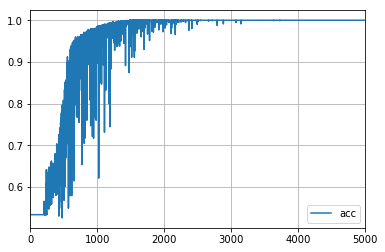

In [14]:
# pandas dataframe. plotting traning accuracy for every epochs. 
df = pd.DataFrame()
df['acc'] = training_accuracy
df.plot(grid=True)


In [15]:
#here decode the output data
def decodeLabel(encodedLabel):
    if encodedLabel == 0:
        return "Other"
    elif encodedLabel == 1:
        return "Fizz"
    elif encodedLabel == 2:
        return "Buzz"
    elif encodedLabel == 3:
        return "FizzBuzz"

# Testing the Model [Software 2.0]

In [16]:
# finding the accuracy by comparing with the known testing labels.

wrong   = 0
right   = 0

predictedTestLabelList = []

for i,j in zip(processedTestingLabel,predictedTestLabel):
    predictedTestLabelList.append(decodeLabel(j))
    
    if np.argmax(i) == j:
        right = right + 1
    else:
        wrong = wrong + 1

print("Errors: " + str(wrong), " Correct :" + str(right))

print("Testing Accuracy: " + str(right/(right+wrong)*100))

# Please input your UBID and personNumber 
testDataInput = testingData['input'].tolist()
testDataLabel = testingData['label'].tolist()

testDataInput.insert(0, "tenzinno")
testDataLabel.insert(0, "50096989")

testDataInput.insert(1, "tenzinno")
testDataLabel.insert(1, "50096989")

predictedTestLabelList.insert(0, "")
predictedTestLabelList.insert(1, "")

#create columns in pandas dataframe with column names input and label, with values test data and respective labels
output = {}
output["input"] = testDataInput
output["label"] = testDataLabel

# create column name predicted label with the predicted labels for the test data
output["predicted_label"] = predictedTestLabelList

# create a csv output file of the pandas dataframe
opdf = pd.DataFrame(output)
opdf.to_csv('output2.csv')

Errors: 0  Correct :100
Testing Accuracy: 100.0
